# ========================================
# Sequential Neutral Network (SNN)
# ========================================

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# -----------------------------
# Reproducibility
# -----------------------------

In [24]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Features and Labels
# -----------------------------

In [16]:
new_df = pd.read_csv('/content/PhiUSIIL_Phishing_URL_Dataset.csv')
X = new_df.drop(columns=['Label', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title', 'URLSimilarityIndex', 'DomainTitleMatchScore', 'URLTitleMatchScore',
                   'TLDLegitimateProb', 'URLCharProb', 'CharContinuationRate', 'NoOfLettersInURL'])
y = new_df['Label']

# Encode labels (binary)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# -----------------------------
# STRICT Train–Test Split
# -----------------------------

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.10,
    random_state=SEED,
    stratify=y_encoded
)


# -----------------------------
# Feature Scaling
# -----------------------------

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

# 4. Transform both sets using the parameters learned from Train
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------------
# Swish Activation
# -----------------------------

In [19]:
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

# -----------------------------
# Model Architecture
# -----------------------------

In [20]:
model = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation(swish),
    Dropout(0.3),

    Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation(swish),
    Dropout(0.3),

    Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation(swish),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │        45,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 708,609 (2.70 MB)

 Trainable params: 705,025 (2.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

# -----------------------------
# Compile
# -----------------------------

In [21]:
optimizer = Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# -----------------------------
# Training (Validation from TRAIN only)
# -----------------------------

In [25]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/100
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 106s 37ms/step - accuracy: 0.9856 - loss: 0.9610 - val_accuracy: 0.9947 - val_loss: 0.1929 - learning_rate: 0.0100
Epoch 2/100
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - accuracy: 0.9893 - loss: 0.1522 - val_accuracy: 0.9969 - val_loss: 0.1393 - learning_rate: 0.0100
Epoch 3/100
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.9906 - loss: 0.1498 - val_accuracy: 0.9962 - val_loss: 0.2554 - learning_rate: 0.0100
Epoch 4/100
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 75s 28ms/step - accuracy: 0.9907 - loss: 0.1543 - val_accuracy: 0.9972 - val_loss: 0.2533 - learning_rate: 0.0100
Epoch 5/100
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9905 - loss: 0.1587
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 72s 27ms/step - accuracy: 0.9905 - loss: 0.1587 - val_accuracy: 0.9936 - val_loss: 0.1471 - learning_rate: 0.0100
Epoch 6/100
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 74s 28ms/step - ac

# -----------------------------
# Evaluation on HOLD-OUT Test Set
# -----------------------------

In [26]:
dl_preds = (model.predict(X_test) > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, dl_preds)
print(f"Deep Learning Test Accuracy: {test_accuracy:.4f}")

737/737 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Deep Learning Test Accuracy: 0.9995


# -----------------------------
# Training History
# -----------------------------

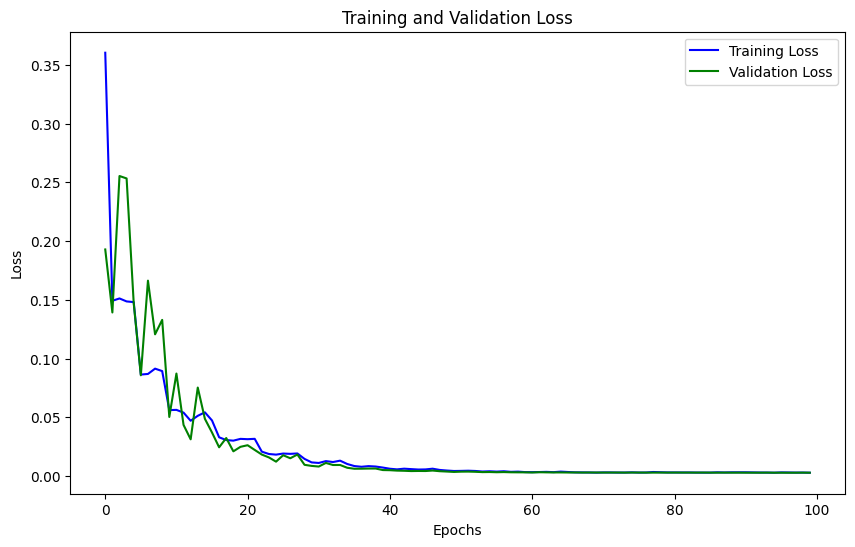

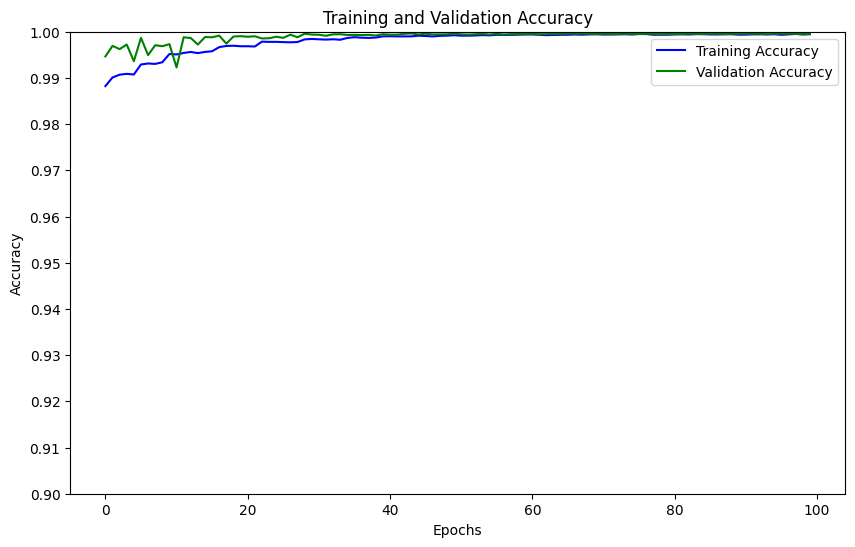

In [27]:
# Evaluation


# Plot training & validation loss
plt.figure(figsize=(10, 6))
# Plot training loss in blue, validation loss in green
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='g')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Remove grid and background color
plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background color to white
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
# Plot training accuracy in blue, validation accuracy in green
plt.plot(history.history['accuracy'], label='Training Accuracy', color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='g')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.98, 1.0)
plt.legend()

# Adjust y-axis to have ticks between 0.9 and 1 with a step of 0.01
plt.yticks(np.arange(0.9, 1.01, 0.01))  # Accuracy ranges from 0.9 to 1, step size of 0.01

# Remove grid and background color
plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background color to white
plt.show()


# -----------------------------
# Calculating Metrics (Test Set)
# -----------------------------

In [29]:
# Model evaluation on test set


# -----------------------------
# Calculating Metrics
# -----------------------------
accuracy = accuracy_score(y_test, dl_preds)
print("Accuracy:", accuracy)

precision = precision_score(y_test, dl_preds)
print("Precision:", precision)

recall = recall_score(y_test, dl_preds)
print("Recall:", recall)

f1 = f1_score(y_test, dl_preds)
print("F1 Score:", f1)

auc_score = roc_auc_score(y_test, dl_preds)
print("ROC_AUC:", auc_score)

pr_auc = average_precision_score(y_test, dl_preds)
print("PR AUC:", pr_auc)

# Note: classification_report returns a string, so assign it to a new variable.
report = classification_report(y_test, dl_preds)
print("\nClassification Report:\n", report)

conf_matrix = confusion_matrix(y_test, dl_preds)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9995335029686174
Precision: 0.999258929894768
Recall: 0.9999258435298479
F1 Score: 0.9995922754735165
ROC_AUC: 0.9994676270645773
PR AUC: 0.9992272372007939

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10095
           1       1.00      1.00      1.00     13485

    accuracy                           1.00     23580
   macro avg       1.00      1.00      1.00     23580
weighted avg       1.00      1.00      1.00     23580


Confusion Matrix:
 [[10085    10]
 [    1 13484]]
